In [1]:
import sys  
import fst
import random
reload(sys)  
sys.setdefaultencoding('utf8')



In [2]:
import random
def ran_lab_prob():
    r = [random.random() for i in range(138)]
    s = sum(r)
    return [i/s for i in r]


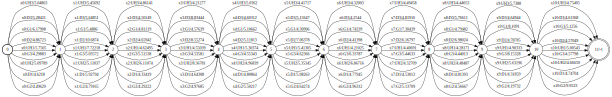

In [75]:
import math
import fst
import random
import numpy as np
symbols = ['G1','G2','G3','UH1','UH2','UH3','D1','D2','D3']
np.random.shuffle(symbols)
def ran_lab_prob():
    r = [random.random() for i in range(138)]
    s = sum(r)
    return [i/s for i in r]

def genBigGraph(label_prob, symbols, seq_len, label='x'):
    t = fst.Transducer()
    sym=fst.SymbolTable()
    x=0
    for j in range(seq_len):
        label_prob = ran_lab_prob()
        for i in range(len(symbols)):
            prob =  label_prob[i] #"%.4f" %
            t.add_arc(0+x, 1+x,str(label+str(j)),symbols[i],-math.log(prob))
        x+=1
    t[j+1].final = -1
    return t

t = genBigGraph(ran_lab_prob,symbols,11)
t


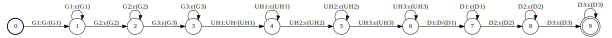

In [72]:
def gen_utt_graph(labels,symdict):
    t2=fst.Transducer()
    #3x3 states for this example
    count = 0
    x = 0
    for l in labels:
        symbols = symdict[l]
        for i in range(len(symbols)):
            if i == 0:
                t2.add_arc(0+x,1+x,symbols[i],str(l+"/"+"("+symbols[i]+")"))
            else:
                t2.add_arc(0+x,1+x,symbols[i],str(sym.find(0)+"("+symbols[i]+")"))
            t2.add_arc(1+x,1+x,symbols[i],str(sym.find(0)+"("+symbols[i]+")"))
            
            x+=1

    t2[x].final=True
    return t2
    

labels  = ['G','UH','D']

symdict={'G': ['G1','G2','G3'],
         'UH': ['UH1','UH2','UH3'],
         'D': ['D1','D2','D3']}
t2 = gen_utt_graph(labels, symdict)
t2

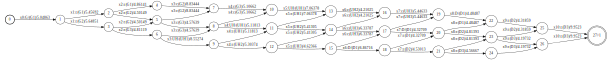

In [76]:
t.osyms = t2.isyms
t3 = t>>t2
t3.write("fst.bin")
t3.isyms.write("fst.isysm.bin")
t3.osyms.write("fst.osysm.bin")

t3

In [50]:
import fst
t3 = fst.read("fst.bin")
t3.isyms=fst.read_symbols("fst.isysm.bin")
t3.osyms=fst.read_symbols("fst.osysm.bin")

Best path using api

In [77]:
t= t3.shortest_path()
t

In [52]:
#make parents dict
def gen_parents_dict(graph):
    parents={}
    for state in graph.states:
        for arc in state.arcs:
            if arc.nextstate in parents:
                parents[arc.nextstate].append(state.stateid)
            else:
                parents[arc.nextstate]=[state.stateid]
    return parents
parents = gen_parents_dict(t3)

#ignore
t=t3
for state in t.states:
    for arc in state.arcs:
        print state.stateid,arc.nextstate,\
        t.isyms.find(arc.ilabel),\
        t.osyms.find(arc.olabel),arc.weight

In [58]:
import numpy as np
def make_prob_dict(graph):
    y_t_s = {} # dictionary to store probabilities indexed by time and label
    n_samps = 10
    F = [0]
    for t in range(n_samps + 1):
        y_t_s[t] = {}
        for s in F:
            arcs = graph[s].arcs
            for a in arcs:
                osym = graph.osyms.find(a.olabel)
                osym = osym[osym.find("(")+1:osym.find(")")]
                y_t_s[t][osym] = np.exp(-1 * float(a.weight))
        F = map(lambda x: map(lambda y: y.nextstate,graph[x].arcs),F)
        F = set([s for ss in F for s in ss])
    return y_t_s
y_t_s = make_prob_dict(t3)
y_t_s

{0: {u'G1': 0.00027155867679014696},
 1: {u'G1': 0.0079956135794283442, u'G2': 0.010161511841687865},
 2: {u'G1': 0.0018690994065258047,
  u'G2': 0.012831947515884231,
  u'G3': 0.0050137897085670404},
 3: {u'G2': 0.013419804542886337,
  u'G3': 0.014335790006200737,
  u'UH1': 0.01136406907535129},
 4: {u'G3': 0.011367098594111016,
  u'UH1': 0.011885150047720703,
  u'UH2': 0.0090918446072047587},
 5: {u'UH1': 0.0015026429328200703,
  u'UH2': 0.0090916321785485463,
  u'UH3': 0.012677958329371138},
 6: {u'D1': 0.0071417955433447523,
  u'UH2': 0.0086410416057035831,
  u'UH3': 0.01433955020980744},
 7: {u'D1': 0.011026036150869757,
  u'D2': 0.0031746292337222451,
  u'UH3': 0.0063474845758382257},
 8: {u'D1': 0.0095492759904630426,
  u'D2': 0.010987916077735778,
  u'D3': 0.014473816389362888},
 9: {u'D2': 0.013166807619911699, u'D3': 0.0091058064062233528},
 10: {u'D3': 0.011693146205095824}}

In [83]:
#forward pass
import numpy as np
symbols = ['G1','G2','G3','UH1','UH2','UH3','D1','D2','D3']

print n_samps
def calc_alpha(n_samps, symbols,y_t_s):
    alpha = {}
    for t in range(n_samps + 1):
        alpha[t] = {}
        for i in range(len(symbols)):
    #         print alpha
            if t == 0:
                if i == 0:
                    alpha[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0))
            else:
                if i == 0:
                        alpha[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0)) * alpha[t-1].setdefault(symbols[i],0.0)
                else:
                    alpha[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0)) * (alpha[t-1].setdefault(symbols[i],0.0) + alpha[t-1].setdefault(symbols[i-1],0.0))
    return alpha
alpha = calc_alpha(10,symbols,y_t_s)
alpha

{0: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.00027155867679014696,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 1: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 2.1712782437548917e-06,
  'G2': 2.759446709916166e-06,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 2: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 4.058334876804659e-09,
  'G2': 6.327080382076771e-08,
  'G3': 1.383528551551685e-08,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 3: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 9.03543881362306e-10,
  'G3': 1.1053767049243294e-09,
  'UH1': 1.5722514027554068e-10,
  'UH2': 0.0,
  'UH3': 0.0},
 4: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 2.283559837205949e-11,
  'UH1': 1.5006212380729483e-11,
  'UH2': 1.4294665437311863e-12,
  'UH3': 0.0},
 5: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 5.686272949279289e-14,
  'UH2': 1.4942714738591877e-13,
  'UH3': 1.81

In [67]:
# backward pass
graph = t3
beta = {}
symbols = ['G1','G2','G3','UH1','UH2','UH3','D1','D2','D3']
def calc_beta(n_samps,symbols,y_t_s):
    for t in range(n_samps,0,-1):
        beta[t] = {}
        for i in range(len(symbols)):
            if t == n_samps:
                if i == len(symbols) - 1:
                    beta[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0))
                else:
                    beta[t][symbols[i]] = 0.0
            else:
                if i < len(symbols) - 1:
                    score = beta[t+1][symbols[i]] + beta[t+1][symbols[i+1]]
                else:
                    score = beta[t+1][symbols[i]]
                beta[t][symbols[i]] = float(y_t_s[t].setdefault(symbols[i],0.0)) * score
    return beta  
calc_beta(10,symbols,y_t_s)

{1: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 1.492552850312459e-19,
  'G2': 4.465777774940874e-19,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 2: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 3.454888818902538e-20,
  'G2': 1.8632596984800635e-17,
  'G3': 2.5315369070997335e-17,
  'UH1': 0.0,
  'UH2': 0.0,
  'UH3': 0.0},
 3: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 1.8484243303700606e-17,
  'G3': 1.4335632313088614e-15,
  'UH1': 3.615585325468675e-15,
  'UH2': 0.0,
  'UH3': 0.0},
 4: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 1.377385433940531e-15,
  'UH1': 9.862151457009095e-14,
  'UH2': 2.1953787899703315e-13,
  'UH3': 0.0},
 5: {'D1': 0.0,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 1.211729996477832e-13,
  'UH2': 8.176704113734077e-12,
  'UH3': 1.5969977718362144e-11},
 6: {'D1': 4.409387887152089e-10,
  'D2': 0.0,
  'D3': 0.0,
  'G1': 0.0,
  'G2': 0.0,
  'G3': 0.0,
  'UH1': 0.0,
  'UH2': 